## Collocation

In [6]:
import warnings
import collections
import json

### Building the dictionaries needed to calculate the PMI
Warning: Do not execute this cells if you already have the dictionaries. Move on to the next section to compute the PMI for a sample.

In [7]:
europarl_dir = "/home/usuaris/veu/javier.ferrando/norm-analysis-of-transformer/exp2_nmt/work/"

# test_de_bpe = europarl_dir + "processed_data/test.bpe.de"
# test_en_bpe = europarl_dir + "processed_data/test.bpe.en"
train_de_bpe = europarl_dir + "processed_data/train.bpe.de"
train_en_bpe = europarl_dir + "processed_data/train.bpe.en"

warnings.simplefilter('ignore')

# with open(test_de_bpe, encoding="utf-8") as fbpe:
#     src_bpe_sents = fbpe.readlines()
# with open(test_en_bpe, encoding="utf-8") as fbpe:
#     tgt_bpe_sents = fbpe.readlines()

with open(train_de_bpe, encoding="utf-8") as fbpe:
    train_src_bpe_sents = fbpe.readlines()
with open(train_en_bpe, encoding="utf-8") as fbpe:
    train_tgt_bpe_sents = fbpe.readlines()



In [8]:
# path = "/home/usuaris/veu/belen.alastruey/europarl_lm_data/dict.txt"
# words = []
# with open(path, 'r+') as dictfile:
#     for line in dictfile:
#         words.append(line.split()[0].replace('▁',''))
#     dictfile.close()
# words = list(set(words))

In [9]:
def update_dict(w, sentence, d):
    for paired_word in sentence:
        d[w][paired_word] += 1

In [12]:
print('Building dictionaries...')
d_src = collections.defaultdict(collections.Counter)
d_tgt = collections.defaultdict(collections.Counter)

print('Start iterating over samples...')
count = 0
for idx, (sample_src, sample_tgt) in enumerate(zip(train_src_bpe_sents, train_tgt_bpe_sents)):
    if idx%100000 == 0:
        print('Processing sample ', idx, ' out of 1.9M')
    sample_src_list = sample_src.replace('▁', '').split()
    sample_tgt_list = sample_tgt.replace('▁', '').split()
    for idx, word in enumerate(sample_tgt_list):
        update_dict(word, sample_src_list, d_src)
        update_dict(word, sample_tgt_list[:(idx-1)], d_tgt)
print('Finished counting.')
print('Saving results in a json...')
d_src_file = open("dictionaries/d_src.json", "w")
d_src_file = json.dump(d_src, d_src_file)
d_tgt_file = open("dictionaries/d_tgt.json", "w")
d_tgt_file = json.dump(d_tgt, d_tgt_file)
print('Finished saving.')

Building dictionaries...
Start iterating over samples...
Processing sample  0  out of 1.9M
Processing sample  100000  out of 1.9M
Processing sample  200000  out of 1.9M
Processing sample  300000  out of 1.9M
Processing sample  400000  out of 1.9M
Processing sample  500000  out of 1.9M
Processing sample  600000  out of 1.9M
Processing sample  700000  out of 1.9M
Processing sample  800000  out of 1.9M
Processing sample  900000  out of 1.9M
Processing sample  1000000  out of 1.9M
Processing sample  1100000  out of 1.9M
Processing sample  1200000  out of 1.9M
Processing sample  1300000  out of 1.9M
Processing sample  1400000  out of 1.9M
Processing sample  1500000  out of 1.9M
Processing sample  1600000  out of 1.9M
Processing sample  1700000  out of 1.9M
Processing sample  1800000  out of 1.9M
Processing sample  1900000  out of 1.9M
Finished counting.
Saving results in a json...
Finished saving.


In [42]:
print('Counting German words...')
d_words_de = collections.Counter()
for sample in train_src_bpe_sents:
    sample = sample.replace('▁', '').split()
    for word in sample:
        d_words_de[word] += 1
print('Finished counting.')
print('Saving results in a json...')
d_words_de_file = open("dictionaries/d_words_de.json", "w")
d_words_de_file = json.dump(d_words_de, d_words_de_file)
print('Finished saving.')

Counting German words...
Finished counting.
Saving results in a json...
Finished saving.


In [15]:
print('Counting English words...')
d_words_en = collections.Counter()
for sample in train_tgt_bpe_sents:
    sample = sample.replace('▁', '').split()
    for word in sample:
        d_words_en[word] += 1
print('Finished counting.')
print('Saving results in a json...')
d_words_en_file = open("dictionaries/d_words_en.json", "w")
d_words_en_file = json.dump(d_words_en, d_words_en_file)
print('Finished saving.')

Counting English words...
Finished counting.
Saving results in a json...
Finished saving.


### Compute PMI for a sample

In [17]:
import os
import torch
import math
torch.cuda.set_device(0)
torch.cuda.current_device()

import warnings
from pathlib import Path
from fairseq_transformer_wrapper import FairseqTransformerHub, parse_single_alignment

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

2022-03-10 13:27:14 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


Load sample

In [18]:
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])


### Alignment test (BPE from Europarl)
test_de_bpe = europarl_dir / "processed_data/test.bpe.de"
test_de_word =  europarl_dir / "processed_data/test.de"
test_en_bpe = europarl_dir / "processed_data/test.bpe.en"
test_en_word = europarl_dir / "processed_data/test.en"
gold_alignment = europarl_dir / "gold_alignment/alignment.talp"


warnings.simplefilter('ignore')

with open(test_de_bpe, encoding="utf-8") as fbpe:
    src_bpe_sents = fbpe.readlines()
with open(test_en_bpe, encoding="utf-8") as fbpe:
    tgt_bpe_sents = fbpe.readlines()
with open(europarl_dir / "data_in_progress/test.uc.de", encoding="utf-8") as fword:
    src_word_sents = fword.readlines()
with open(europarl_dir / "data_in_progress/test.uc.en", encoding="utf-8") as fword:
    tgt_word_sents = fword.readlines()


model_type = 'baseline'
suffix = '_q_self_attn_head' #'_q_wandb'
seed = 2253                  # 1234

if model_type == 'baseline':
    suffix=''

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best{suffix}.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(),
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
num_layers = 6
eos_id = hub.tgt_dict.index("</s>")

In [19]:
# Select a sample
i = 2 #3

In [20]:
# Gold alignment data
src_word_sent = src_word_sents[i]
print(src_word_sent)
tgt_word_sent = tgt_word_sents[i]
print(tgt_word_sent)

src_tok_str = src_bpe_sents[i].strip()
src_tok = src_tok_str.split()

tgt_tok_str = tgt_bpe_sents[i].strip()
tgt_tok = tgt_tok_str.split()
src_tensor = torch.tensor([hub.src_dict.index(t) for t in src_tok_str.split()] + [eos_id])#.to(device)
#src_tensor = torch.tensor([hub.tgt_dict.index("<unk>") for t in src_tok_str.split()] + [eos_id])#.to(device)


tgt_tensor = torch.tensor([hub.tgt_dict.index(t) for t in tgt_tok_str.split()] + [eos_id])#.to(device)

Sicher - wenn ein Drogenabhängiger zum Dealer wird , dann ist es richtig und notwendig , daß er dafür auch vor dem Gesetz zur Rechenschaft gezogen wird .

Of course , if a drug addict becomes a pusher , then it is right and necessary that he should pay and answer before the law also .



In [21]:
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")

print("\n\nBEAM SEARCH\n")
for pred in hub.generate(src_tensor, 5):
    pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
    score = pred['score'].item()
    print(f"{score} \t {pred_sent}")



GREEDY DECODING

Predicted sentence: 	 certainly course , if a drug addict becomes a dealer , it it is right and necessary that he should be attention be before the law . .


BEAM SEARCH

-0.44968464970588684 	 of course , if a drug addict becomes a dealer , then it is right and necessary that he should also be held to account before the law .
-0.45907098054885864 	 of course , if a drug addict becomes a dealer , then it is right and necessary that he should be held to account before the law .
-0.4609526991844177 	 of course , if a drug addict becomes a dealer , it is right and necessary that he should be held to account before the law .
-0.4631890058517456 	 certainly , if a drug addict becomes a dealer , it is right and necessary that he should be held to account before the law .
-0.5051776766777039 	 of course , if a drug addict becomes a dealer , then it is right and necessary that he should be held to account before the law too .


In [32]:
pred = [word.replace('▁', '') for word in pred_tok]
tgt = [word.replace('▁', '') for word in tgt_tok]
src = src_bpe_sents[i].replace('▁', '').split()


d_words_de = json.load(open("dictionaries/d_words_de.json"))
d_words_en = json.load(open("dictionaries/d_words_en.json"))
d_src = json.load(open("dictionaries/d_src.json"))
d_tgt = json.load(open("dictionaries/d_tgt.json"))

n_en_words = len(d_words_en.keys())
n_de_words = len(d_words_de.keys())


Compute PMI

In [33]:
def src_pred_pmi(word_pred, word_src):
    if (word_pred in d_src.keys()) and (word_src in d_src[word_pred].keys()):
        src_score = d_src[word_pred][word_src]
        pmi_src = math.log(n_en_words*n_de_words, 2)+math.log(src_score/(d_words_de[word_src]*d_words_en[word_pred]), 2)
        return pmi_src
    else:
        return 0


def tgt_pred_pmi(word_pred, word_tgt):
    if (word_pred in d_tgt.keys()) and (word_tgt in d_tgt[word_pred].keys()):
        tgt_score = d_tgt[word_pred][word_tgt]
        pmi_tgt = math.log(n_en_words*n_en_words, 2)+math.log(tgt_score/(d_words_en[word_tgt]*d_words_en[word_pred]), 2)
        return pmi_tgt
    else:
        return 0


In [34]:
all_pmis_enc = []
for pred_word in pred:
    row = []
    for src_word in src:
        row.append(src_pred_pmi(pred_word,src_word))
    all_pmis_enc.append(row)

all_pmis_dec = []
for pred_word in pred:
    row = []
    for tgt_word in tgt:
        row.append(tgt_pred_pmi(pred_word,tgt_word))
    all_pmis_dec.append(row)

all_pmis_enc = np.array(all_pmis_enc)
all_pmis_dec = np.array(all_pmis_dec)
tri_mask = np.ma.make_mask(np.triu(np.ones(len(tgt)), 1))
all_pmis_dec[tri_mask] = 0
all_pmis = np.concatenate((all_pmis_enc, all_pmis_dec), axis=1)
all_pmis = all_pmis/all_pmis.sum(axis=-1,keepdims=True)

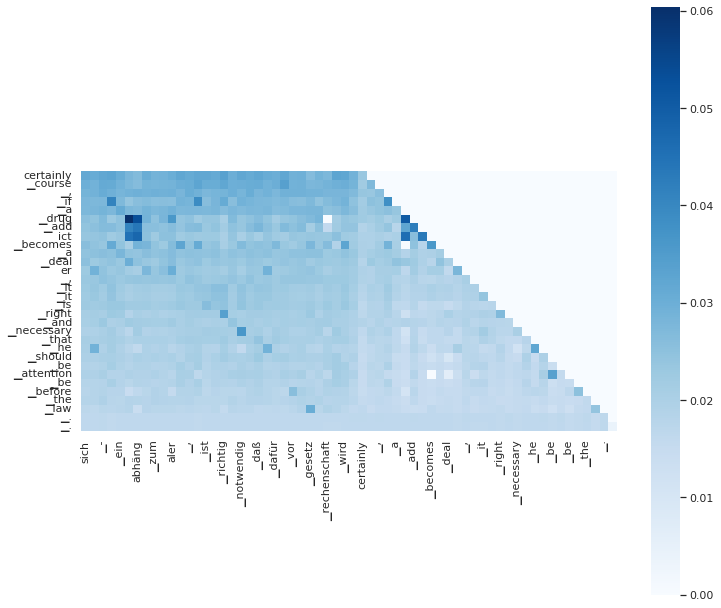

In [35]:
df = pd.DataFrame(all_pmis, columns = src_tok + pred_tok, index = pred_tok)
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)

Check whether the encoder or the decoder have the higher PMI for every predicted token

In [36]:
for w, e, d in zip(pred, list(all_pmis_enc.max(axis=1)), list(all_pmis_dec.max(axis=1))):
    if e > d:
        print(w, '--> encoder')
    else:
        print(w, '--> decoder')

certainly --> encoder
course --> encoder
, --> encoder
if --> encoder
a --> encoder
drug --> encoder
add --> encoder
ict --> encoder
becomes --> decoder
a --> encoder
deal --> encoder
er --> encoder
, --> encoder
it --> encoder
it --> encoder
is --> encoder
right --> encoder
and --> encoder
necessary --> encoder
that --> encoder
he --> decoder
should --> encoder
be --> encoder
attention --> decoder
be --> encoder
before --> encoder
the --> encoder
law --> encoder
. --> encoder
. --> encoder
